GCN [SEMI-SUPERVISED CLASSIFICATION WITH
GRAPH CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1609.02907)

In [1]:
from load import Load_Data_Construct_A_For_GNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = Load_Data_Construct_A_For_GNN(dir1='/content/drive/MyDrive/cora.content.txt', dir2='/content/drive/MyDrive/cora.cites', device=device)

In [4]:
fts, lbls, A, idx_train, idx_val, idx_test = data.load_data()

In [5]:
fts.shape, lbls, A.shape

(torch.Size([2708, 1433]),
 tensor([0, 2, 1,  ..., 4, 3, 0], device='cuda:0'),
 torch.Size([2708, 2708]))

In [6]:
class GCN_layer(nn.Module):
  def __init__(self, nfeat, nhid, bias=True):
    super().__init__()
    self.W = nn.Parameter(torch.randn(nfeat, nhid))
    if bias:
      self.bias = nn.Parameter(torch.randn(nhid))
    else:
      self.register_parameter('bias', None)
    self.reset_params()

  def reset_params(self):
    stdv = 1. / math.sqrt(self.W.data.size(1))
    self.W.data.uniform_(-stdv, stdv)
    if self.bias is not None:
      self.bias.data.uniform_(-stdv, stdv)


  def forward(self, x, adj):
    x = torch.matmul(x, self.W)
    x = torch.matmul(adj, x)
    if self.bias is not None:
      return x + self.bias
    else:
      return x


In [7]:
class GCN(nn.Module):
  def __init__(self, nfeat, nhid, nclass):
    super().__init__()
    self.layer1 = GCN_layer(nfeat, nhid)
    self.layer2 = GCN_layer(nhid, nclass)

  def forward(self, x, adj):
    hidden = self.layer1(x, adj)
    hidden = F.relu(hidden)
    hidden = F.dropout(hidden, 0.5, training=self.training)
    out = self.layer2(hidden, adj)
    out = F.log_softmax(out, dim=1)
    return out, hidden

In [8]:
model = GCN(fts.shape[1], 128, lbls.max().item()+1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def valid(y_hat, lbls):
  _, pred = torch.max(y_hat, 1)
  acc = (pred == lbls).sum().item() / len(lbls)
  return acc

In [10]:
best_val_loss = float('inf')

In [11]:
loss_train_lst = []
loss_val_lst = []
acc_train_lst = []
acc_val_lst = []

In [12]:
for epoch in range(200):
  model.train()
  y_hat, _ = model(fts, A)
  loss_train = F.nll_loss(y_hat[idx_train], lbls[idx_train])
  loss_train_lst.append(loss_train.item())
  acc_train = valid(y_hat[idx_train], lbls[idx_train])
  acc_train_lst.append(acc_train)
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  model.eval()
  with torch.no_grad():
    y_hat, _ = model(fts, A)
    loss_val = F.nll_loss(y_hat[idx_val], lbls[idx_val])
    loss_val_lst.append(loss_val.item())
    acc_val = valid(y_hat[idx_val], lbls[idx_val])
    acc_val_lst.append(acc_val)

  print('epoch:{}, loss_train:{:.4f}, acc_train:{:.4f}, loss_val:{:.4f}, acc_val:{:.4f}'.format(
      epoch+1, loss_train, acc_train, loss_val, acc_val
  ))

  if loss_val < best_val_loss:
    best_val_loss = loss_val
    torch.save(model.state_dict(), 'best_model.pth')

epoch:1, loss_train:1.9336, acc_train:0.0857, loss_val:1.9052, acc_val:0.1100
epoch:2, loss_train:1.9194, acc_train:0.0857, loss_val:1.8992, acc_val:0.1100
epoch:3, loss_train:1.9154, acc_train:0.0857, loss_val:1.8933, acc_val:0.1100
epoch:4, loss_train:1.9016, acc_train:0.1714, loss_val:1.8876, acc_val:0.1100
epoch:5, loss_train:1.9024, acc_train:0.1714, loss_val:1.8820, acc_val:0.1525
epoch:6, loss_train:1.8864, acc_train:0.2143, loss_val:1.8764, acc_val:0.3362
epoch:7, loss_train:1.8914, acc_train:0.2000, loss_val:1.8709, acc_val:0.3575
epoch:8, loss_train:1.8776, acc_train:0.2571, loss_val:1.8656, acc_val:0.3362
epoch:9, loss_train:1.8730, acc_train:0.2643, loss_val:1.8602, acc_val:0.3350
epoch:10, loss_train:1.8643, acc_train:0.3286, loss_val:1.8549, acc_val:0.3337
epoch:11, loss_train:1.8579, acc_train:0.3000, loss_val:1.8497, acc_val:0.3337
epoch:12, loss_train:1.8584, acc_train:0.2929, loss_val:1.8446, acc_val:0.3337
epoch:13, loss_train:1.8403, acc_train:0.2929, loss_val:1.839

In [13]:
epochs = list(np.arange(1, 201))

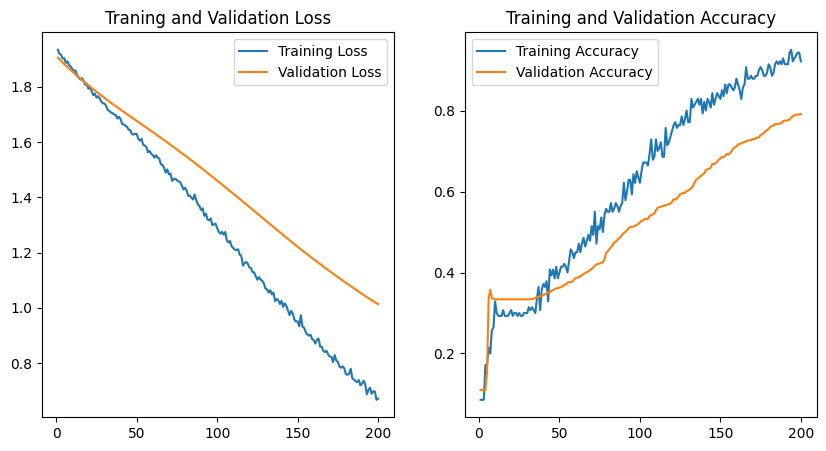

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train_lst, label='Training Loss')
plt.plot(epochs, loss_val_lst, label='Validation Loss')
plt.title('Traning and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train_lst, label='Training Accuracy')
plt.plot(epochs, acc_val_lst, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [15]:
!pip install scikit-learn

In [17]:
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE

In [18]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [26]:
model.eval()
y_hat, hidden = model(fts, A)

In [20]:
f1_scores = f1_score(lbls[idx_test].cpu().detach().numpy(), y_hat[idx_test].cpu().detach().numpy().argmax(axis=1), average='micro')
f1_scores

0.7160000000000001

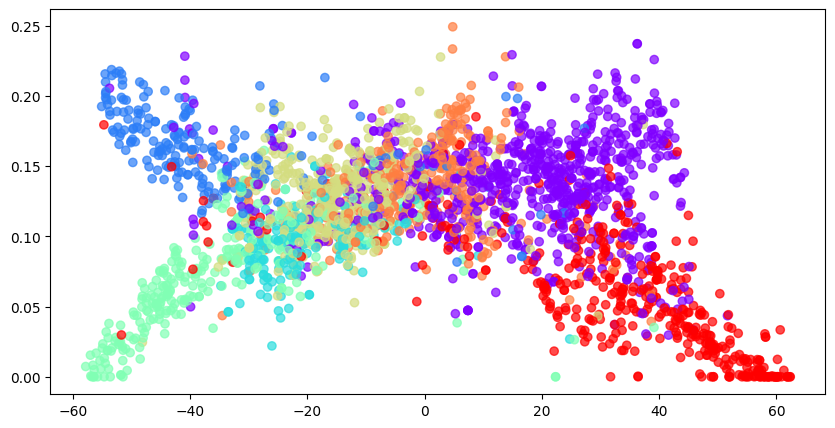

In [27]:
hidden = hidden.cpu().detach().numpy()
tsne = TSNE(n_components=2)
hidden_2d = tsne.fit_transform(hidden)
plt.figure(figsize=(10, 5))
scatter = plt.scatter(hidden_2d[:, 0], hidden[:, 1], c=lbls.cpu().detach().numpy(), cmap='rainbow', alpha=0.7)
